In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  report = classification_report(y_true, y_pred)
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  y_train_pred = model.predict(X_train)
  results_train = classification_metrics(y_train, y_train_pred,
                                         output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                         label='Training Data')
  print()
  y_test_pred = model.predict(X_test)
  results_test = classification_metrics(y_test, y_test_pred,
                                        output_dict=True,figsize=figsize,
                                        colorbar=colorbar, cmap=cmap_test,
                                        label='Test Data' )
  if output_dict == True:
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [3]:
#Loading data
df = pd.read_csv('Data/Car_Insurance_Claim.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [4]:
df.tail()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
9995,323164,26-39,female,majority,10-19y,university,upper class,0.582787,1.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,1,0.0
9996,910346,26-39,female,majority,10-19y,none,middle class,0.522231,1.0,after 2015,0.0,1.0,32765,NaN,sedan,1,0,0,0.0
9997,468409,26-39,male,majority,0-9y,high school,middle class,0.470940,1.0,before 2015,0.0,1.0,10238,14000.0,sedan,0,0,0,0.0
9998,903459,26-39,female,majority,10-19y,high school,poverty,0.364185,0.0,before 2015,0.0,1.0,10238,13000.0,sedan,2,0,1,1.0
9999,442696,26-39,female,majority,0-9y,none,working class,0.435225,1.0,before 2015,1.0,1.0,10238,13000.0,sedan,0,0,0,0.0


In [5]:
#Checking for duplicates
df.duplicated().sum()

0

In [6]:
#Checking for missing values
df.isna().sum()

ID                       0
AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

- Credit score and annual milage both have missing values which I will replace with the means during the preprocess further along the code .

In [7]:
# Converting data types
df['MARRIED'] = df['MARRIED'].astype(int)
df['MARRIED'].dtypes

dtype('int32')

In [8]:
df['CHILDREN'] = df['CHILDREN'].astype(int)
df['CHILDREN'].dtypes

dtype('int32')

In [9]:
df.describe()

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,10000.000000,9018.000000,10000.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,500521.906800,0.515813,0.697000,0.498200,0.688800,19864.548400,11697.003207,1.482900,0.23920,1.056300,0.313300
std,290030.768758,0.137688,0.459578,0.500022,0.463008,18915.613855,2818.434528,2.241966,0.55499,1.652454,0.463858
min,101.000000,0.053358,0.000000,0.000000,0.000000,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.000000
25%,249638.500000,0.417191,0.000000,0.000000,0.000000,10238.000000,10000.000000,0.000000,0.00000,0.000000,0.000000
50%,501777.000000,0.525033,1.000000,0.000000,1.000000,10238.000000,12000.000000,0.000000,0.00000,0.000000,0.000000
75%,753974.500000,0.618312,1.000000,1.000000,1.000000,32765.000000,14000.000000,2.000000,0.00000,2.000000,1.000000
max,999976.000000,0.960819,1.000000,1.000000,1.000000,92101.000000,22000.000000,22.000000,6.00000,15.000000,1.000000


In [10]:
df.describe(exclude='number')

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,VEHICLE_YEAR,VEHICLE_TYPE
count,10000,10000,10000,10000,10000,10000,10000,10000
unique,4,2,2,4,3,4,2,2
top,26-39,female,majority,0-9y,high school,upper class,before 2015,sedan
freq,3063,5010,9012,3530,4157,4336,6967,9523


In [11]:
#EDA
corr = df.corr(numeric_only=True)

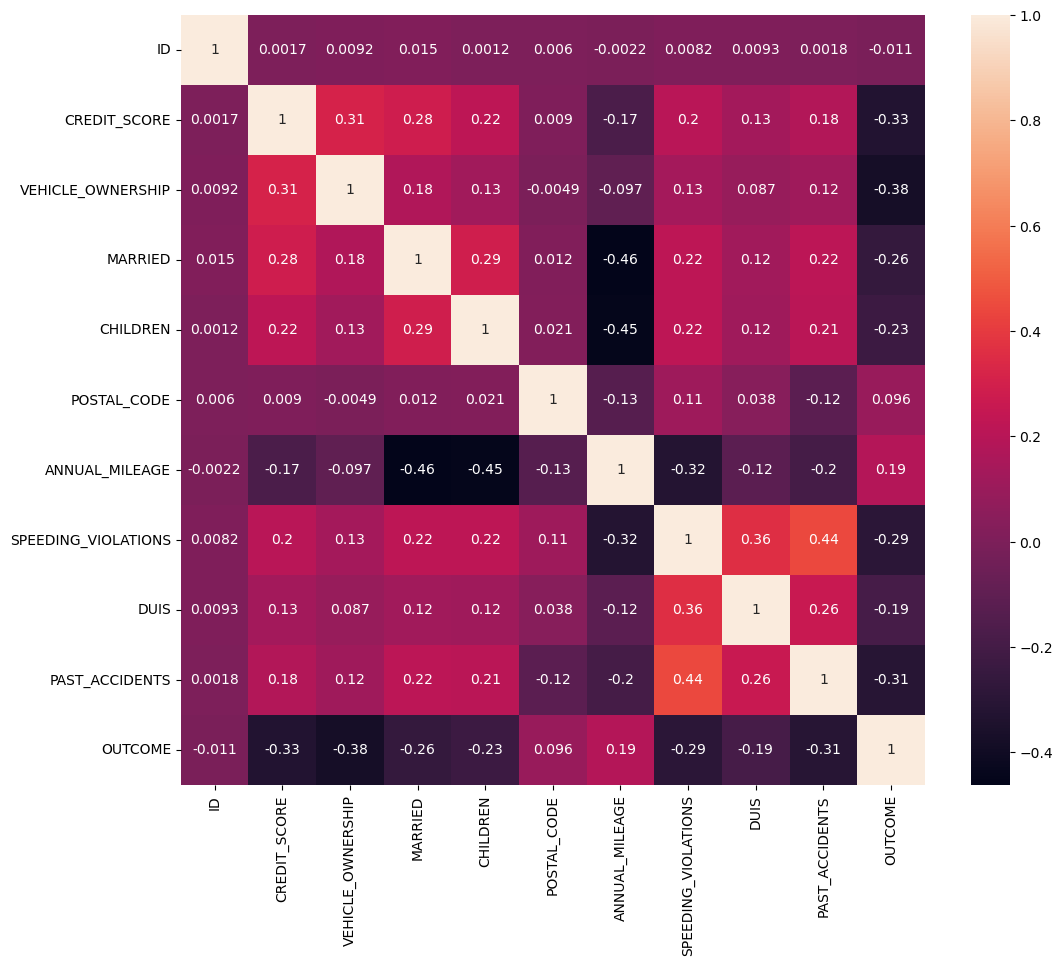

In [12]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr, annot=True, ax=ax);

- Our data does not have features correlated to the target.

<Axes: >

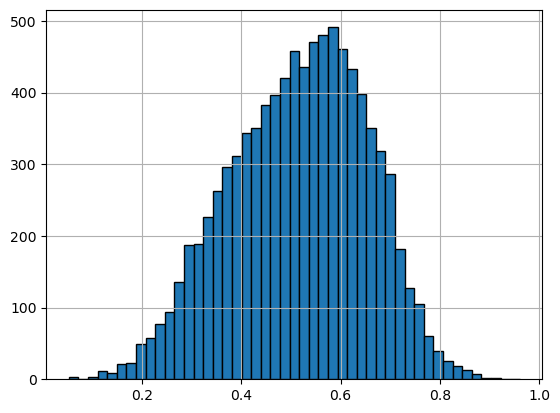

In [13]:
df['CREDIT_SCORE'].hist(bins='auto', edgecolor='black')

- The average credit score of our customers falls just under 600.

In [14]:
df['OUTCOME'].value_counts(normalize=True)

0.0    0.6867
1.0    0.3133
Name: OUTCOME, dtype: float64

In [15]:
#Train, test split
X = df.drop(columns=['OUTCOME'])
y = df['OUTCOME']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
y_train.value_counts(normalize=True)

0.0    0.685867
1.0    0.314133
Name: OUTCOME, dtype: float64

In [17]:
y_test.value_counts(normalize=True)

0.0    0.6892
1.0    0.3108
Name: OUTCOME, dtype: float64

In [18]:
#Ordinal Encoder
df['EDUCATION'].value_counts()

high school    4157
university     3928
none           1915
Name: EDUCATION, dtype: int64

In [19]:
df['INCOME'].value_counts()

upper class      4336
middle class     2138
poverty          1814
working class    1712
Name: INCOME, dtype: int64

In [20]:
df['AGE'].value_counts()

26-39    3063
40-64    2931
16-25    2016
65+      1990
Name: AGE, dtype: int64

In [21]:
ord_cols = ['EDUCATION', 'INCOME', 'AGE']
ord_cols

['EDUCATION', 'INCOME', 'AGE']

In [22]:
age_order = ['16-25', '26-39', '40-64', '65+']
education_order = ['none', 'high school', 'university']
income_order = ['poverty', 'working class', 'middle class', 'upper class']
ord_orders = [education_order, income_order, age_order]
ord_encoder = OrdinalEncoder(categories=ord_orders)
scaler = StandardScaler()
ord_pipe = make_pipeline(ord_encoder, scaler)
ord_pipe

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(categories=[['none', 'high school',
                                             'university'],
                                            ['poverty', 'working class',
                                             'middle class', 'upper class'],
                                            ['16-25', '26-39', '40-64',
                                             '65+']])),
                ('standardscaler', StandardScaler())])

In [23]:
ord_tuple = ('Ordinal', ord_pipe, ord_cols)

In [24]:
#One Hot Encoder
cat_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns
cat_cols

Index(['GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'VEHICLE_YEAR', 'VEHICLE_TYPE'], dtype='object')

In [25]:
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_pipe = make_pipeline(ohe_encoder)
ohe_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [26]:
ohe_tuple = ('Categorical', ohe_pipe, cat_cols)

In [27]:
#Numerical 
num_cols = X_train.select_dtypes('number').columns
num_cols

Index(['ID', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS'],
      dtype='object')

In [28]:
impute_median = SimpleImputer(strategy='mean')
scaler = StandardScaler()
num_pipe = make_pipeline(impute_median, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [29]:
num_tuple = ('Numeric', num_pipe, num_cols)

In [30]:
#Column transformer
col_trans = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple], verbose_feature_names_out=False)
col_trans

ColumnTransformer(transformers=[('Numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['ID', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS'],
      dtype='object')),
                                ('Ordinal',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEnco...
                                                                              'upper '
                                                                              'class'],
                                                                             ['16-25',
                                                                              '26-39',
                                                                              '40-64',
                                                                              '65+']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['EDUCATION', 'INCOME', 'AGE']),
                                ('Categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'VEHICLE_YEAR', 'VEHICLE_TYPE'], dtype='object'))],
                  verbose_feature_names_out=False)

In [31]:
#Fitting column transformer
X_train_proc = col_trans.fit_transform(X_train)
X_test_proc = col_trans.transform(X_test)

In [32]:
#Fitting logistic regression for base model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_proc, y_train)

LogisticRegression(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      5144
         1.0       0.77      0.72      0.75      2356

    accuracy                           0.84      7500
   macro avg       0.82      0.81      0.82      7500
weighted avg       0.84      0.84      0.84      7500



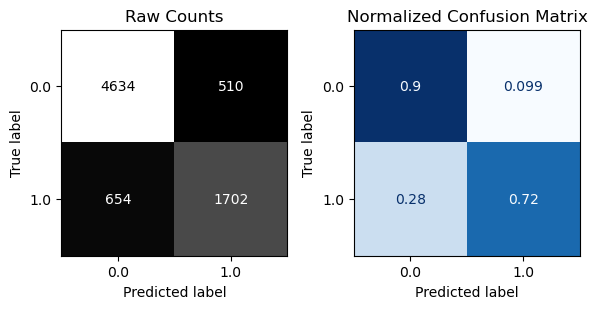


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89      1723
         1.0       0.76      0.71      0.74       777

    accuracy                           0.84      2500
   macro avg       0.82      0.81      0.81      2500
weighted avg       0.84      0.84      0.84      2500



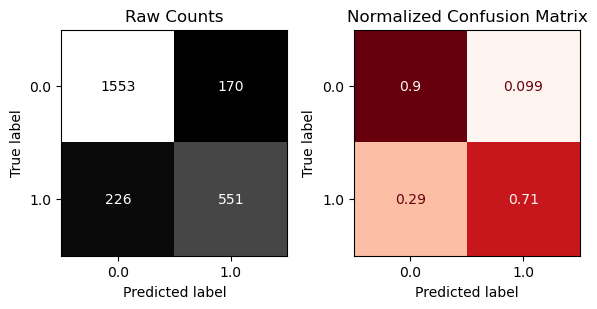

In [33]:
#Evaluating base model
evaluate_classification(log_reg, X_train_proc, y_train, X_test_proc, y_test)

In [34]:
#Finding important features from base model
importances = permutation_importance(log_reg, X_test_proc, y_test, n_repeats=5, random_state=42)
importances.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [35]:
permutation_importances = pd.Series(importances['importances_mean'],index=X_test_proc.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances

DRIVING_EXPERIENCE_0-9y      0.10320
VEHICLE_OWNERSHIP            0.04536
VEHICLE_YEAR_before 2015     0.01512
VEHICLE_YEAR_after 2015      0.01512
DRIVING_EXPERIENCE_20-29y    0.00896
DRIVING_EXPERIENCE_30y+      0.00888
POSTAL_CODE                  0.00800
DRIVING_EXPERIENCE_10-19y    0.00616
GENDER_female                0.00560
GENDER_male                  0.00560
MARRIED                      0.00448
PAST_ACCIDENTS               0.00392
CHILDREN                     0.00360
ANNUAL_MILEAGE               0.00160
AGE                          0.00064
EDUCATION                    0.00064
ID                           0.00008
VEHICLE_TYPE_sedan           0.00000
VEHICLE_TYPE_sports car      0.00000
INCOME                      -0.00024
RACE_minority               -0.00032
RACE_majority               -0.00032
CREDIT_SCORE                -0.00048
DUIS                        -0.00048
SPEEDING_VIOLATIONS         -0.00280
Name: permutation importance, dtype: float64

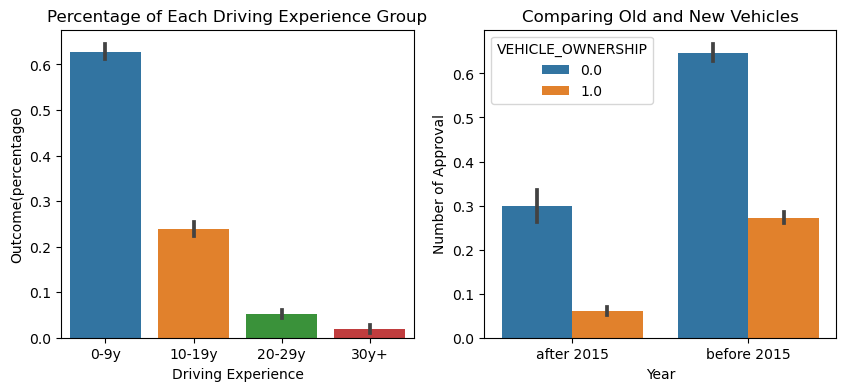

In [36]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
sns.barplot(data=df, x = 'DRIVING_EXPERIENCE', y = 'OUTCOME', ax=axes[0])
axes[0].set_title('Percentage of Each Driving Experience Group', fontsize = 12)
axes[0].set_ylabel("Outcome(percentage0")
axes[0].set_xlabel("Driving Experience")
# Subplot 2
sns.barplot(data=df, hue='VEHICLE_OWNERSHIP', x='VEHICLE_YEAR', y='OUTCOME', ax=axes[1])
axes[1].set_title('Comparing Old and New Vehicles', fontsize = 12)
axes[1].set_ylabel("Number of Approval")
axes[1].set_xlabel("Year");

- Most people making a claim are drivers with less experience.
- Drivers with older model cars make more claims than those with new cars.
- Drivers that rent or lease cars make more claims than drivers who owns their car.

In [37]:
#Imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [38]:
#Scaling data for kmeans clustering
X_train_scaled = StandardScaler().fit_transform(X_train_proc)
X_train_scaled

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,...,RACE_majority,RACE_minority,DRIVING_EXPERIENCE_0-9y,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,VEHICLE_YEAR_after 2015,VEHICLE_YEAR_before 2015,VEHICLE_TYPE_sedan,VEHICLE_TYPE_sports car
4901,0.331565,1.375201e+00,0.660062,1.000533,0.674880,3.867776,-1.017414e-16,-0.659296,-0.432581,-0.643278,...,0.32912,-0.32912,1.349693,-0.696315,-0.517651,-0.347478,-0.652161,0.652161,0.220917,-0.220917
4375,-1.015047,-1.696215e+00,0.660062,-0.999467,-1.481745,0.694321,1.085747e-01,-0.659296,-0.432581,-0.643278,...,0.32912,-0.32912,1.349693,-0.696315,-0.517651,-0.347478,-0.652161,0.652161,0.220917,-0.220917
6698,-0.632931,-3.836931e-16,0.660062,1.000533,0.674880,-0.510486,-1.017414e-16,-0.659296,-0.432581,1.147363,...,0.32912,-0.32912,-0.740909,1.436132,-0.517651,-0.347478,-0.652161,0.652161,0.220917,-0.220917
9805,0.198738,-4.709184e-01,0.660062,-0.999467,-1.481745,-0.510486,3.111111e+00,0.229004,-0.432581,-0.643278,...,0.32912,-0.32912,-0.740909,1.436132,-0.517651,-0.347478,-0.652161,0.652161,0.220917,-0.220917
1101,0.185106,-2.796544e+00,0.660062,1.000533,-1.481745,-0.510486,-6.420595e-01,-0.659296,-0.432581,-0.643278,...,0.32912,-0.32912,1.349693,-0.696315,-0.517651,-0.347478,-0.652161,0.652161,0.220917,-0.220917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,1.368845,1.366450e+00,0.660062,1.000533,0.674880,-0.510486,8.592088e-01,0.673153,1.348077,1.147363,...,0.32912,-0.32912,-0.740909,-0.696315,-0.517651,2.877877,-0.652161,0.652161,0.220917,-0.220917
5191,0.596295,4.619159e-02,0.660062,-0.999467,-1.481745,-0.510486,-2.667424e-01,-0.659296,-0.432581,-0.643278,...,0.32912,-0.32912,1.349693,-0.696315,-0.517651,-0.347478,1.533364,-1.533364,0.220917,-0.220917
5390,-0.712853,8.478394e-01,0.660062,1.000533,0.674880,-0.510486,-1.017414e-16,-0.659296,-0.432581,0.550483,...,0.32912,-0.32912,-0.740909,-0.696315,-0.517651,2.877877,1.533364,-1.533364,0.220917,-0.220917
860,0.951788,1.732853e+00,0.660062,1.000533,0.674880,-0.510486,-1.392694e+00,-0.215146,-0.432581,2.341124,...,0.32912,-0.32912,-0.740909,-0.696315,1.931803,-0.347478,1.533364,-1.533364,0.220917,-0.220917


In [39]:
X_test_scaled = StandardScaler().fit_transform(X_test_proc)
X_test_scaled

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,...,RACE_majority,RACE_minority,DRIVING_EXPERIENCE_0-9y,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,VEHICLE_YEAR_after 2015,VEHICLE_YEAR_before 2015,VEHICLE_TYPE_sedan,VEHICLE_TYPE_sports car
6252,-0.148903,0.195957,-1.521726,1.012883,0.664020,0.647356,-0.242523,-0.216209,-0.426622,-0.628007,...,0.337025,-0.337025,-0.731865,1.393261,-0.521169,-0.328871,-0.682844,0.682844,0.232299,-0.232299
4684,-1.151318,0.284817,0.657149,1.012883,-1.505979,-0.504958,-1.343025,0.687674,1.444528,1.904280,...,0.337025,-0.337025,-0.731865,-0.717741,1.918762,-0.328871,-0.682844,0.682844,0.232299,-0.232299
1731,0.330492,-2.019450,-1.521726,-0.987281,-1.505979,0.647356,0.491145,-0.668150,-0.426622,-0.628007,...,-2.967140,2.967140,1.366372,-0.717741,-0.521169,-0.328871,-0.682844,0.682844,0.232299,-0.232299
4742,0.689749,0.004001,0.657149,-0.987281,-1.505979,-0.504958,0.857979,-0.668150,-0.426622,-0.628007,...,0.337025,-0.337025,1.366372,-0.717741,-0.521169,-0.328871,-0.682844,0.682844,0.232299,-0.232299
4521,-1.159992,1.303174,0.657149,1.012883,0.664020,-0.504958,-0.609357,0.235733,-0.426622,-0.628007,...,0.337025,-0.337025,-0.731865,-0.717741,1.918762,-0.328871,1.464464,-1.464464,-4.304794,4.304794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4862,-0.757795,0.514714,0.657149,1.012883,0.664020,-0.504958,-0.976191,3.851265,1.444528,1.271208,...,-2.967140,2.967140,-0.731865,-0.717741,-0.521169,3.040707,1.464464,-1.464464,0.232299,-0.232299
7025,-0.951416,-0.212965,-1.521726,-0.987281,-1.505979,3.682544,0.018191,-0.668150,-0.426622,-0.628007,...,-2.967140,2.967140,1.366372,-0.717741,-0.521169,-0.328871,-0.682844,0.682844,0.232299,-0.232299
7647,0.590631,0.109101,0.657149,1.012883,0.664020,0.647356,-1.343025,-0.216209,1.444528,0.005065,...,0.337025,-0.337025,-0.731865,1.393261,-0.521169,-0.328871,-0.682844,0.682844,0.232299,-0.232299
7161,0.477523,0.004001,0.657149,1.012883,0.664020,-0.504958,-1.709859,-0.216209,-0.426622,0.638136,...,0.337025,-0.337025,-0.731865,1.393261,-0.521169,-0.328871,1.464464,-1.464464,0.232299,-0.232299


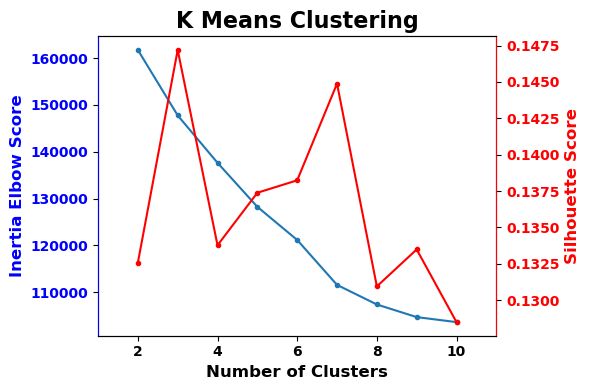

In [40]:
inertias = []
silhouette_scores = []

for k in range (2,11):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X_train_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train_scaled, kmeans.labels_))

fig, ax1 = plt.subplots(figsize=(6,4))
plt.title('K Means Clustering' , fontsize = 16 , weight='bold')

ax1.plot(range(2,11), inertias, marker='.')
ax1.set_ylabel('Inertia Elbow Score', color='blue', fontsize=12, weight='bold')
plt.xlabel('Number of Clusters', fontsize=12, weight='bold')
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')
ax1.tick_params(axis='y', labelcolor='b')
ax1.xaxis.set_ticks(np.arange(0, 12, 2))

plt.xlim([1,11])

ax2 = ax1.twinx()
ax2.plot(range(2,11), silhouette_scores, color='r', marker='.')
ax2.set_ylabel('Silhouette Score', color='r', fontsize=12, weight='bold')
plt.yticks(fontsize=10, weight='bold')
ax2.tick_params(axis='y', labelcolor='r')
ax2.spines['right'].set_color('r')

ax2.spines['left'].set_color('blue');

plt.tight_layout()
plt.show;

- I will use 3 clusters for this model because the silhouette score peaks at 3 and there is no noticeable elbow in the inertia elbow score.

In [41]:
#Fitting KMeans
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42)
kmeans.fit(X_train_scaled)

KMeans(n_clusters=3, n_init='auto', random_state=42)

In [42]:
#Creating clusters column 
X_train_scaled['CLUSTER'] = kmeans.labels_
X_train_scaled.head()

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,...,RACE_minority,DRIVING_EXPERIENCE_0-9y,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,VEHICLE_YEAR_after 2015,VEHICLE_YEAR_before 2015,VEHICLE_TYPE_sedan,VEHICLE_TYPE_sports car,CLUSTER
4901,0.331565,1.375201e+00,0.660062,1.000533,0.674880,3.867776,-1.017414e-16,-0.659296,-0.432581,-0.643278,...,-0.32912,1.349693,-0.696315,-0.517651,-0.347478,-0.652161,0.652161,0.220917,-0.220917,0
4375,-1.015047,-1.696215e+00,0.660062,-0.999467,-1.481745,0.694321,1.085747e-01,-0.659296,-0.432581,-0.643278,...,-0.32912,1.349693,-0.696315,-0.517651,-0.347478,-0.652161,0.652161,0.220917,-0.220917,1
6698,-0.632931,-3.836931e-16,0.660062,1.000533,0.674880,-0.510486,-1.017414e-16,-0.659296,-0.432581,1.147363,...,-0.32912,-0.740909,1.436132,-0.517651,-0.347478,-0.652161,0.652161,0.220917,-0.220917,0
9805,0.198738,-4.709184e-01,0.660062,-0.999467,-1.481745,-0.510486,3.111111e+00,0.229004,-0.432581,-0.643278,...,-0.32912,-0.740909,1.436132,-0.517651,-0.347478,-0.652161,0.652161,0.220917,-0.220917,1
1101,0.185106,-2.796544e+00,0.660062,1.000533,-1.481745,-0.510486,-6.420595e-01,-0.659296,-0.432581,-0.643278,...,-0.32912,1.349693,-0.696315,-0.517651,-0.347478,-0.652161,0.652161,0.220917,-0.220917,1


In [43]:
X_test_scaled['CLUSTER'] = kmeans.predict(X_test_scaled)
X_test_scaled.head()

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,...,RACE_minority,DRIVING_EXPERIENCE_0-9y,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,VEHICLE_YEAR_after 2015,VEHICLE_YEAR_before 2015,VEHICLE_TYPE_sedan,VEHICLE_TYPE_sports car,CLUSTER
6252,-0.148903,0.195957,-1.521726,1.012883,0.664020,0.647356,-0.242523,-0.216209,-0.426622,-0.628007,...,-0.337025,-0.731865,1.393261,-0.521169,-0.328871,-0.682844,0.682844,0.232299,-0.232299,1
4684,-1.151318,0.284817,0.657149,1.012883,-1.505979,-0.504958,-1.343025,0.687674,1.444528,1.904280,...,-0.337025,-0.731865,-0.717741,1.918762,-0.328871,-0.682844,0.682844,0.232299,-0.232299,0
1731,0.330492,-2.019450,-1.521726,-0.987281,-1.505979,0.647356,0.491145,-0.668150,-0.426622,-0.628007,...,2.967140,1.366372,-0.717741,-0.521169,-0.328871,-0.682844,0.682844,0.232299,-0.232299,1
4742,0.689749,0.004001,0.657149,-0.987281,-1.505979,-0.504958,0.857979,-0.668150,-0.426622,-0.628007,...,-0.337025,1.366372,-0.717741,-0.521169,-0.328871,-0.682844,0.682844,0.232299,-0.232299,1
4521,-1.159992,1.303174,0.657149,1.012883,0.664020,-0.504958,-0.609357,0.235733,-0.426622,-0.628007,...,-0.337025,-0.731865,-0.717741,1.918762,-0.328871,1.464464,-1.464464,-4.304794,4.304794,2


In [44]:
#Fitting logistic regression for kmeans model
kmeans_log_reg = LogisticRegression(random_state=42)
kmeans_log_reg.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      5144
         1.0       0.77      0.72      0.75      2356

    accuracy                           0.85      7500
   macro avg       0.82      0.81      0.82      7500
weighted avg       0.84      0.85      0.84      7500



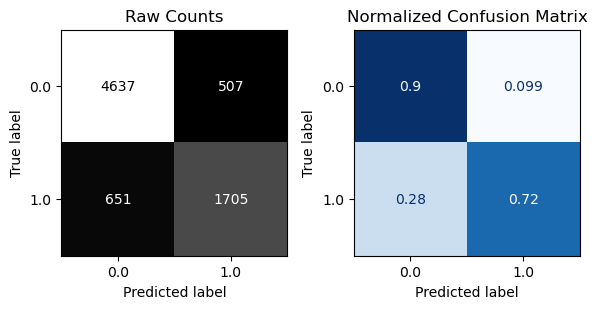


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      1723
         1.0       0.76      0.72      0.74       777

    accuracy                           0.84      2500
   macro avg       0.82      0.81      0.81      2500
weighted avg       0.84      0.84      0.84      2500



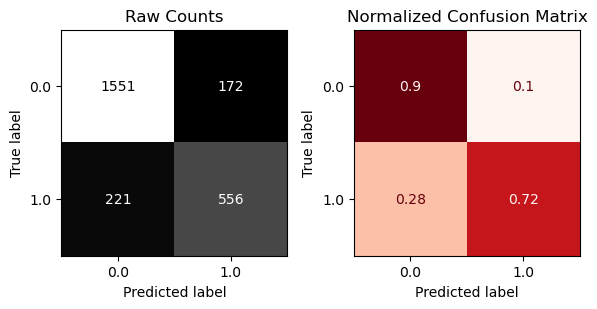

In [45]:
#Evaluating kmeans model
evaluate_classification(kmeans_log_reg, X_train_scaled, y_train, X_test_scaled, y_test)

In [46]:
#Finding important features from  model
kmeans_importances = permutation_importance(kmeans_log_reg, X_train_scaled, y_train)

X_train_imp = pd.Series(kmeans_importances['importances_mean'], index=kmeans_log_reg.feature_names_in_)
X_train_imp.sort_values(ascending=False)

DRIVING_EXPERIENCE_0-9y      0.077840
VEHICLE_OWNERSHIP            0.048160
DRIVING_EXPERIENCE_20-29y    0.019200
DRIVING_EXPERIENCE_30y+      0.014853
POSTAL_CODE                  0.012933
VEHICLE_YEAR_before 2015     0.010213
VEHICLE_YEAR_after 2015      0.010213
GENDER_female                0.008773
GENDER_male                  0.008773
PAST_ACCIDENTS               0.004667
ANNUAL_MILEAGE               0.003440
MARRIED                      0.003440
CLUSTER                      0.001867
INCOME                       0.001307
ID                           0.000933
SPEEDING_VIOLATIONS          0.000507
DUIS                         0.000400
CREDIT_SCORE                 0.000240
DRIVING_EXPERIENCE_10-19y    0.000160
VEHICLE_TYPE_sedan           0.000133
VEHICLE_TYPE_sports car      0.000133
CHILDREN                     0.000107
AGE                          0.000053
EDUCATION                   -0.000107
RACE_majority               -0.000587
RACE_minority               -0.000587
dtype: float

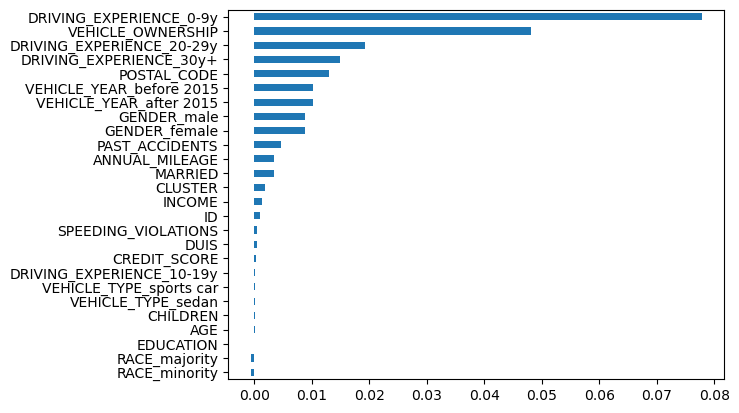

In [47]:
X_train_imp.sort_values().plot(kind='barh');

In [48]:
threshold = 0
important_features = X_train_imp > threshold

## Use the filter to select features to keep
X_train_sel = X_train_scaled.loc[:,important_features]
X_test_sel = X_test_scaled.loc[:, important_features]
print(X_train_sel.shape)
X_train_sel.columns

(7500, 23)


Index(['ID', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS', 'INCOME', 'AGE', 'GENDER_female', 'GENDER_male',
       'DRIVING_EXPERIENCE_0-9y', 'DRIVING_EXPERIENCE_10-19y',
       'DRIVING_EXPERIENCE_20-29y', 'DRIVING_EXPERIENCE_30y+',
       'VEHICLE_YEAR_after 2015', 'VEHICLE_YEAR_before 2015',
       'VEHICLE_TYPE_sedan', 'VEHICLE_TYPE_sports car', 'CLUSTER'],
      dtype='object')

In [49]:
#Fitting logistic regression for permutation selection model
log_reg_sel = LogisticRegression(random_state=42)
log_reg_sel.fit(X_train_sel, y_train)

LogisticRegression(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      5144
         1.0       0.77      0.72      0.74      2356

    accuracy                           0.84      7500
   macro avg       0.82      0.81      0.82      7500
weighted avg       0.84      0.84      0.84      7500



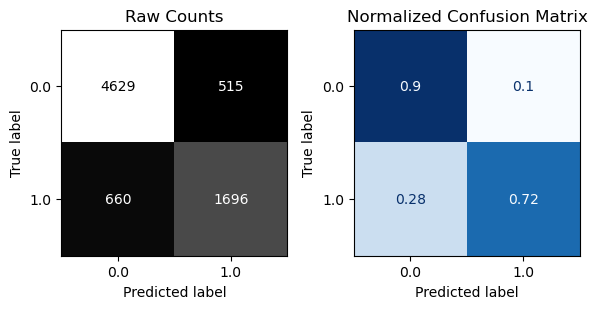


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89      1723
         1.0       0.76      0.71      0.74       777

    accuracy                           0.84      2500
   macro avg       0.82      0.81      0.81      2500
weighted avg       0.84      0.84      0.84      2500



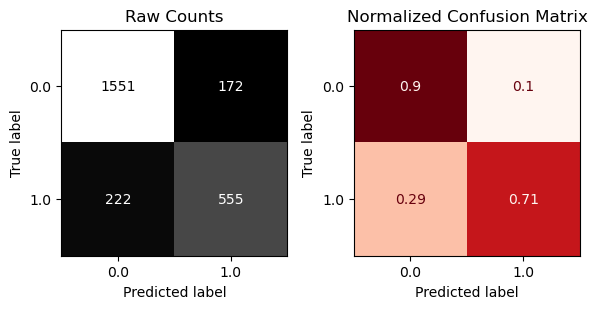

In [50]:
#Evaluating permutation selection model
evaluate_classification(log_reg_sel, X_train_sel, y_train, X_test_sel, y_test)

In [51]:
#Finding important features in permutation selection
importances = permutation_importance(log_reg_sel, X_test_sel, y_test, n_repeats=3, random_state=42)
importances.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [52]:
permutation_importances = pd.Series(importances['importances_mean'],index=X_test_sel.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances

DRIVING_EXPERIENCE_0-9y      8.146667e-02
VEHICLE_OWNERSHIP            4.546667e-02
DRIVING_EXPERIENCE_20-29y    1.746667e-02
VEHICLE_YEAR_before 2015     1.586667e-02
VEHICLE_YEAR_after 2015      1.586667e-02
DRIVING_EXPERIENCE_30y+      1.280000e-02
POSTAL_CODE                  5.733333e-03
GENDER_female                5.066667e-03
GENDER_male                  5.066667e-03
MARRIED                      4.400000e-03
CHILDREN                     3.333333e-03
ANNUAL_MILEAGE               3.333333e-03
CLUSTER                      2.666667e-03
PAST_ACCIDENTS               1.200000e-03
ID                           9.333333e-04
INCOME                       3.700743e-17
VEHICLE_TYPE_sedan          -5.333333e-04
VEHICLE_TYPE_sports car     -5.333333e-04
DRIVING_EXPERIENCE_10-19y   -1.333333e-03
CREDIT_SCORE                -1.333333e-03
DUIS                        -1.600000e-03
AGE                         -1.733333e-03
SPEEDING_VIOLATIONS         -2.400000e-03
Name: permutation importance, dtyp

- The permutation selection model performed the same as the default model, and the kmeans had a slightly lower accuracy.
- I would consider using the permutation selection model over the default model.
- Although they performed the same, the permutation selection has less features. Pros in having less features are our models making faster prediction, and saving disk space.

## Neural Network

In [53]:
from keras.models import Sequential
from tensorflow.keras import metrics
from keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from keras_tuner import HyperParameters as hp
import keras_tuner as kt
import tensorflow as tf
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

In [54]:
def eval_classification(true, pred, name, labels=None):
    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""

    print(name, '\n')
    print(classification_report(true, pred, target_names=labels))
    ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=labels, )

    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

def plot_history(history):
  """Takes a keras model learning history and plots each metric"""

  metrics = history.history.keys()

  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

In [55]:
def build_class_model():
# Build your model
    class_model = Sequential()
    class_model.add(Dense(10, input_dim=X_train_proc.shape[1], activation='relu'))
    class_model.add(Dense(1, activation='sigmoid'))
    
    class_model.summary()
    precision = Precision(name='precision')
    recall = Recall(name='recall')

    class_model.compile(optimizer = 'adam', loss = 'bce',
                    metrics = ['accuracy', precision, recall])
    
    return class_model

In [56]:
class_model1 = build_class_model()
class_model1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                260       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [57]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)

In [58]:
history = class_model1.fit(X_train_proc, y_train,
                        validation_split=.2,
                        epochs=50,
                        verbose=0, callbacks = [early_stop])

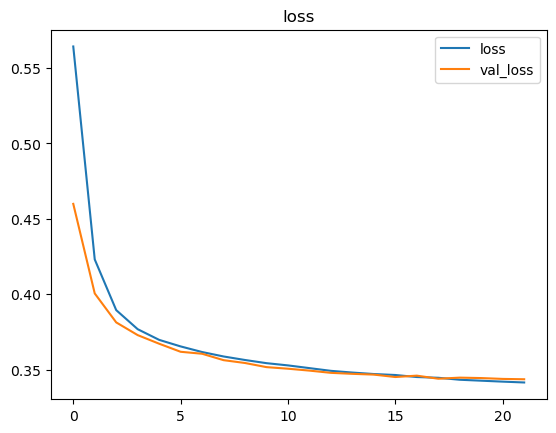

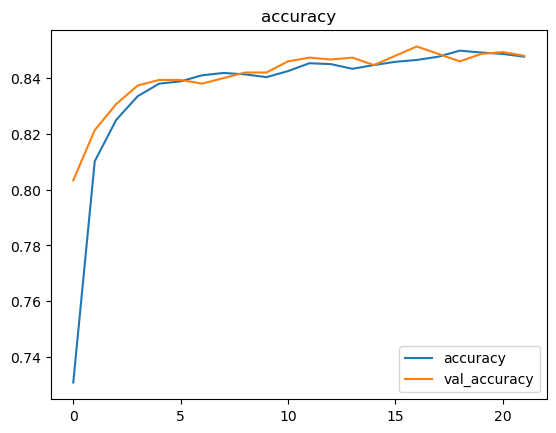

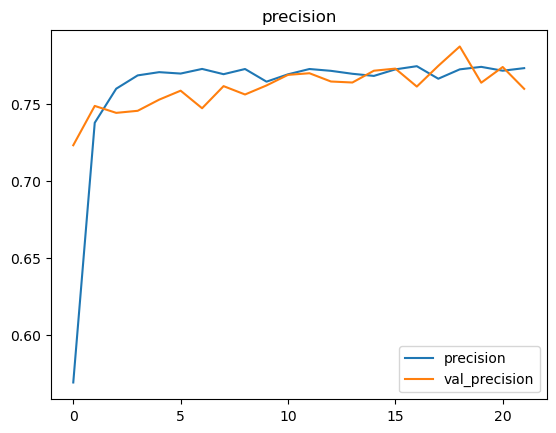

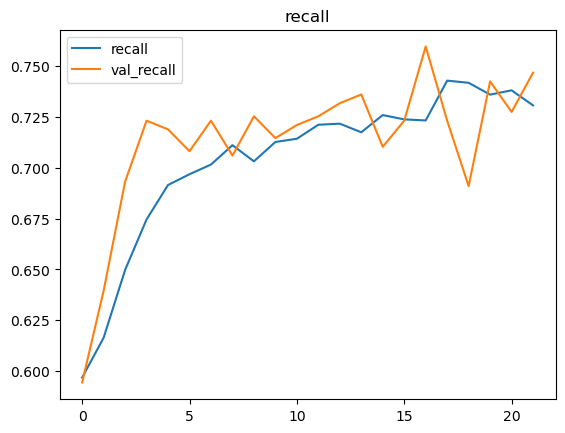

In [59]:
plot_history(history);

In [60]:
# Get predictions
train_pred_proba = class_model1.predict(X_train_proc)
test_pred_proba = class_model1.predict(X_test_proc)


# round predictions to integers instead of floats using np.rint()
train_preds = np.rint(train_pred_proba)
test_preds = np.rint(test_pred_proba)

# the following code should show whole number predictions, 1.0 or 0.0
print(test_preds[:5])
print(train_preds[:5])

79/79 [==============================] - 0s 359us/step
[[1.]
 [0.]
 [1.]
 [1.]
 [0.]]
[[1.]
 [1.]
 [0.]
 [0.]
 [0.]]


class model train 

              precision    recall  f1-score   support

    No Claim       0.89      0.90      0.89      5144
       Claim       0.77      0.75      0.76      2356

    accuracy                           0.85      7500
   macro avg       0.83      0.82      0.83      7500
weighted avg       0.85      0.85      0.85      7500



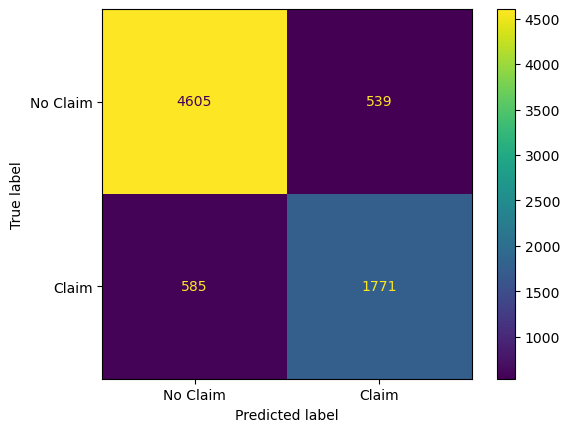

class model test 

              precision    recall  f1-score   support

    No Claim       0.88      0.90      0.89      1723
       Claim       0.76      0.72      0.74       777

    accuracy                           0.84      2500
   macro avg       0.82      0.81      0.81      2500
weighted avg       0.84      0.84      0.84      2500



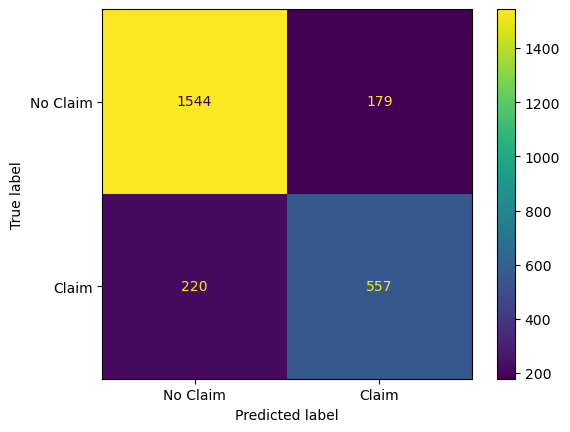

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
class model train,0.766667,0.751698,0.759108,0.850133
class model test,0.756793,0.716860,0.736286,0.840400


In [61]:
labels = ['No Claim', 'Claim']

# Evaluate your model using the custom function eval_classification()
train_scores = eval_classification(y_train, train_preds,
                                   name='class model train',
                                  labels=labels)
test_scores = eval_classification(y_test, test_preds,
                                   name='class model test',
                                  labels=labels)

# concatenate the two dataframes to compare the model on train and test data
class_scores = pd.concat([train_scores, test_scores])
class_scores

- In our loss graph I see there is low variance. For the next model I will add a dropout layer to learn more about the data.

In [62]:
def build_class_model(hp):
# Build your model
    class_model = Sequential()
    class_model.add(Dense(10, input_dim=X_train_proc.shape[1], activation='relu'))
    class_model.add(Dense(units=hp.Int(name='units', min_value=10, max_value=50, step=5), activation='sigmoid'))
    class_model.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.5, step=0.1)))
    class_model.add(Dense(1, activation='sigmoid'))

    class_model.compile(optimizer=hp.Choice('optimizer',['rmsprop','nadam','adam']),
                  loss='bce',
                  metrics=['accuracy',
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Precision(name='precision')])
    
    return class_model

In [63]:
import os
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [64]:
tuner = kt.Hyperband(build_class_model,
                     objective='val_accuracy',
                     max_epochs=100,
                     directory=folder,
                     overwrite=True,
                     seed=42,
                     project_name='tuning')

In [65]:
tuner.search(X_train_proc, y_train,  epochs=100,
             validation_data = (X_test_proc, y_test), callbacks = [early_stop])

Trial 172 Complete [00h 00m 02s]
val_accuracy: 0.8420000076293945

Best val_accuracy So Far: 0.847599983215332
Total elapsed time: 00h 05m 16s
INFO:tensorflow:Oracle triggered exit


In [66]:
best_hps=tuner.get_best_hyperparameters()[0]
best_hps.values

{'units': 30,
 'dropout_value': 0.0,
 'optimizer': 'nadam',
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 4,
 'tuner/round': 4,
 'tuner/trial_id': '0142'}

In [67]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                260       
                                                                 
 dense_1 (Dense)             (None, 30)                330       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________


In [68]:
result = best_model.evaluate(X_test_proc, y_test, return_dict=True)
result

79/79 [==============================] - 0s 577us/step - loss: 0.3548 - accuracy: 0.8476 - recall: 0.7452 - precision: 0.7598


{'loss': 0.35478970408439636,
 'accuracy': 0.847599983215332,
 'recall': 0.7451737523078918,
 'precision': 0.7598425149917603}

In [69]:
y_pred_test = best_model.predict(X_test_proc)
y_pred_test = np.round(y_pred_test)
y_pred_test[:5]

79/79 [==============================] - 0s 372us/step


array([[0.],
       [0.],
       [1.],
       [1.],
       [0.]], dtype=float32)

              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89      1723
         1.0       0.76      0.75      0.75       777

    accuracy                           0.85      2500
   macro avg       0.82      0.82      0.82      2500
weighted avg       0.85      0.85      0.85      2500



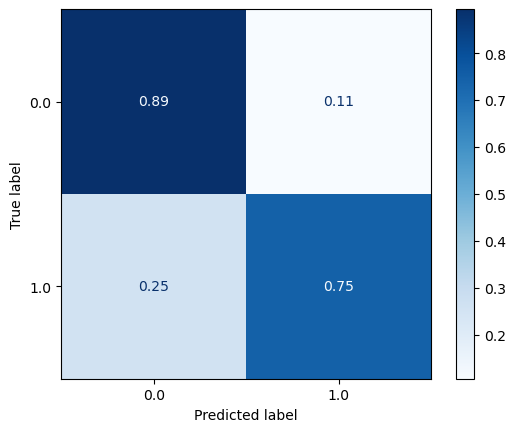

In [70]:
print(classification_report(y_test, y_pred_test))
 
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues',
                                       normalize='true');